In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel
import statsmodels.api as smi
from scipy.special import ndtri
from scipy.integrate import quad
from scipy.stats import t
from scipy import stats
from statsmodels.formula.api import ols

In [3]:
# таблица данных об учениках и проведении теста. Будем считать, что сделали случайную и независимую выборку 
df = pd.read_csv('StudentsPerformance.csv')
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [4]:
df = df.rename(columns={'test preparation course':'test_preparation_course', 'math score':'math_score', 'reading score': 'reading_score','writing score':'writing_score','race/ethnicity':'race'})
df

,gender,race,parental level of education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


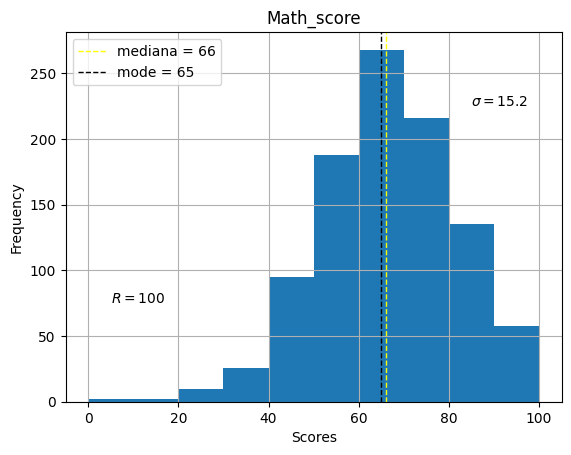

In [5]:
# построение результатов теста по математике
# анализ мер тенденции и мер изменчивости
fig, axs = plt.subplots()
axs.set_title('Math_score')
axs.set_xlabel('Scores')
axs.set_ylabel('Frequency')
axs.axvline(df.math_score.median(), color='yellow', linestyle='dashed', linewidth=1, label = f'mediana = {int(df.math_score.median())}')
#axs.axvline(df.math_score.mean(), color='yellow', linestyle='dashed', linewidth=1, label = 'mean')
axs.axvline(df.math_score.mode()[0], color='black', linestyle='dashed', linewidth=1, label = f'mode = {df.math_score.mode()[0]}')
df.math_score.hist(ax=axs)
plt.legend(loc='upper left')
plt.text(85, 225, f'$\sigma = {round(df.math_score.std(),1)}$')
plt.text(5, 75, f'$R = {round(df.math_score.max() - df.math_score.min(),1)}$');

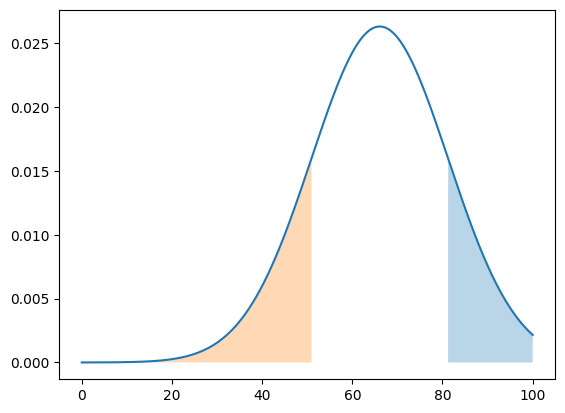

In [6]:
# доверительный интервал для результатов по математике (68%)
 
mean, std  = df.math_score.mean(), df.math_score.std()
# создадим пространство из 1000 точек в диапазоне +/- трех СКО от среднего значения
x = np.linspace(df.math_score.min(), df.math_score.max(), 1000)
 
# рассчитаем значения по оси y с помощью метода .pdf()
# т.е. функции плотности распределения
f = norm.pdf(x, mean, std)
 
# и построим график
plt.plot(x, f)
 
# дополнительно создадим точки на оси х для закрашенной области
px_1 = np.linspace(mean + std, df.math_score.max(), 1000)
px_2 = np.linspace(df.math_score.min(), mean - std, 1000)
 
# и заполним в пределах этих точек по оси x пространство
# от кривой нормального распределения до оси y = 0
plt.fill_between(px_1, norm.pdf(px_1, mean, std), alpha = 0.3)
plt.fill_between(px_2, norm.pdf(px_2, mean, std), alpha = 0.3)
 
# выведем оба графика
plt.show()

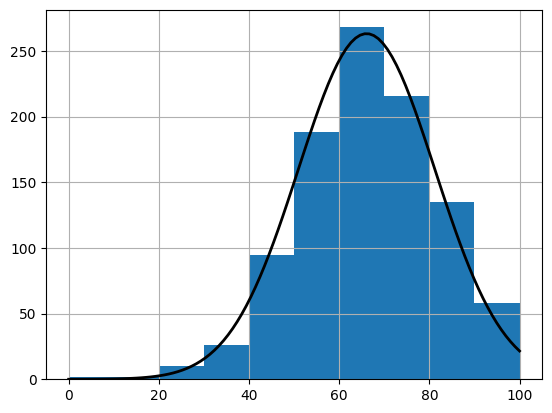

In [7]:
# проверка данных на нормальность по гистограмме
mu, std = norm.fit(df.math_score.head(999))
x = np.linspace(0, 100, 100)
p = norm.pdf(x, mu, std) # функция плотности вероятности
df.math_score.hist()
plt.plot(x, p*10**4, 'k', linewidth=2);


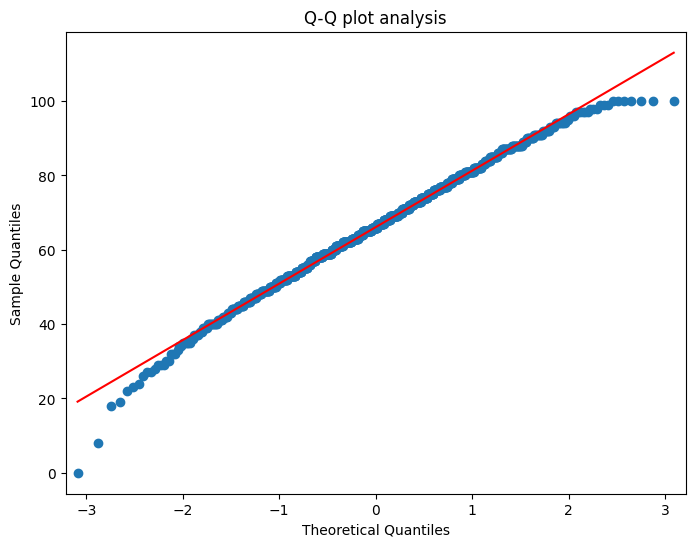

In [8]:
# проверка нормальность данных через Q-Q plot
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Q-Q plot analysis')
smi.qqplot(df.math_score, line="r", ax = ax) 
plt.show() 
# получился отрицательный скат графика, что говорит о том, что большиство данных находится правее центра картины

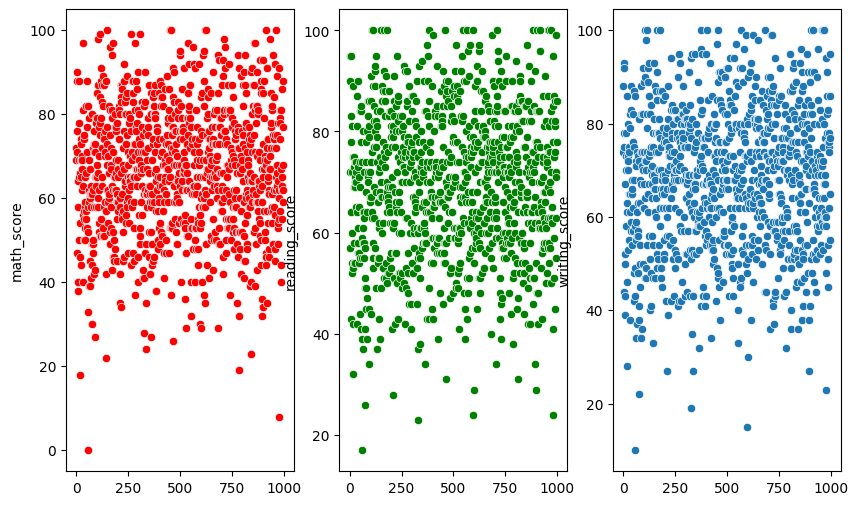

In [9]:
# построение диаграммы рассеяния
fig, axs = plt.subplots(1,3,figsize = (10,6))
sns.scatterplot(df.math_score, ax = axs[0], color='r')
sns.scatterplot(df.reading_score, ax = axs[1], color ='g')
sns.scatterplot(df.writing_score, ax = axs[2]);

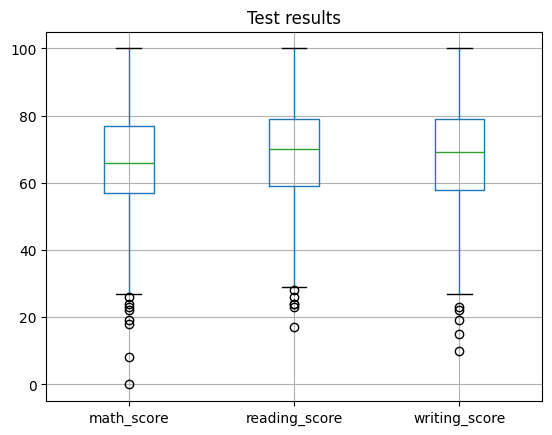

In [10]:
# как видно из предыдущего построения, диаграммы рассеяния при большой плотности данных сложны для анализа
# построение результатов тестов на boxplot. По величине выбросов можно сказать, какой предмет написали хуже всего
plt.title('Test results')
df.boxplot(column=['math_score', 'reading_score', 'writing_score']);

In [11]:
# функция построения доверительных интервалов
def plot_confidence_interval(x, values, color_chart, z=1.96, horizontal_line_width=0.25, label = None):

    mean = values.mean()
    stdev = values.std()
    confidence_interval = z * stdev / np.sqrt(len(values)) # z = 1.96 - 95 % интервал, т.к. нормальное распределение

    left = x - horizontal_line_width / 2 # значение линии слева по оси ОX
    top = mean - confidence_interval   # верхняя граница среднего
    right = x + horizontal_line_width / 2 # значение линии справа по оси ОX
    bottom = mean + confidence_interval # нижняя граница среднего

    # построение линий по двум точкам
    plt.plot([x, x], [top, bottom], color=color_chart, label = label) 
    plt.plot([left, right], [top, top], color=color_chart) 
    plt.plot([left, right], [bottom, bottom], color=color_chart)
    # обозначение среднего значения
    plt.plot(x, mean, 'o', color='#f44336') 

    return mean, confidence_interval

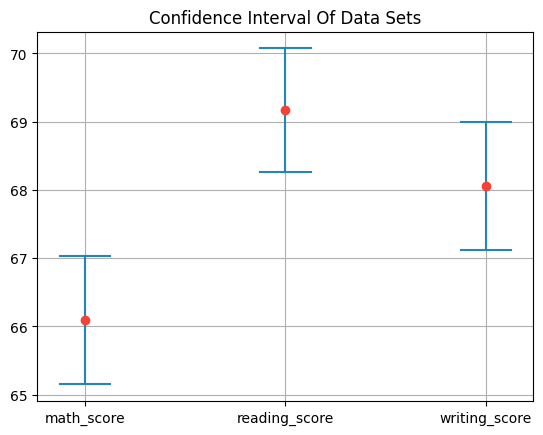

In [12]:
plt.xticks([1, 2, 3], ['math_score', 'reading_score', 'writing_score'])
plt.title('Confidence Interval Of Data Sets')
plot_confidence_interval(1, df.math_score, color_chart = '#2187bb')
plot_confidence_interval(2, df.reading_score, color_chart = '#2187bb')
plot_confidence_interval(3, df.writing_score, color_chart = '#2187bb')
plt.grid()

In [13]:
# t - тест Стюдента. Количественная переменная - оценки по математике, номинативная - пол студентов
# нулевая гипотеза H_0 - одинаковые средние, нет различий между полом
# ограничение метода - нормальность данных и гомогенность дисперсий
# существует проблема множественного стравнения t-теста - это можно отдельно показать
n = len(df.math_score) # размер выборки
df1 = df.groupby('gender').aggregate({'math_score': 'mean'})
df1 = df1.rename(columns={'math_score':"mean"})
df1['std'] = df.groupby('gender').aggregate({'math_score': 'std'})
df1

,mean,std
gender,,
female,63.633205,15.491453
male,68.728216,14.356277


In [14]:
# расчёт вручную t-критерия для сравнения двух средних
t_test = (df1.loc['female']['mean'] - df1.loc['male']['mean'])/np.sqrt(df1.loc['female']['std']**2/482+ df1.loc['male']['std']**2/518)
print(t_test)

-5.383260578852784


In [15]:
df_male = df.loc[df.gender =='male'].math_score
df_female = df.loc[df.gender =='female'].math_score

In [16]:
# p-уровень значимости оказался < 0.05, отклоняется нулевая гипотеза, получили значимые различия
t_statistic, p_value = ttest_ind(df_male, df_female)
print('Значение t-критерия Стьюдента=',round(t_statistic,2))
print('Значение p-уровня значимости=',round(p_value,9))

Значение t-критерия Стьюдента= 5.38
Значение p-уровня значимости= 9.1e-08


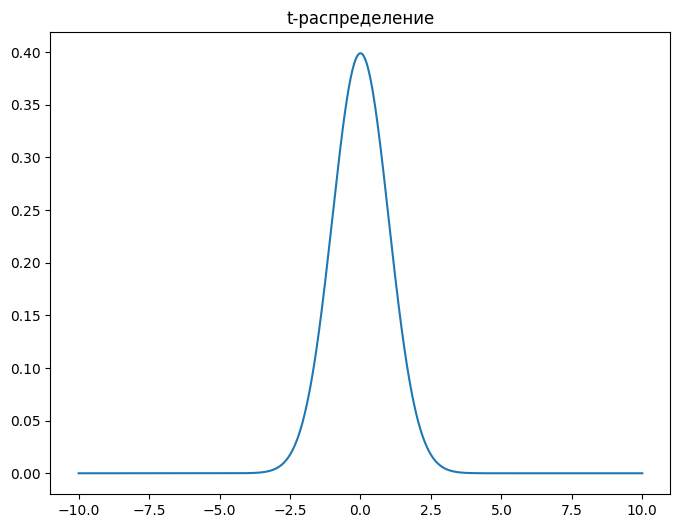

In [17]:
# можно построить t-распределение из библиотеки scipy.stats
fig, ax = plt.subplots(figsize = (8, 6))
distribution = np.linspace(-10, 10, 1000)
plot = plt.plot(distribution, t(998,0).pdf(distribution))
ax.set_title('t-распределение');
# на данном графике t-распределения t_критерий не будет видно, поскольку p_value = 9.12e-08

In [18]:
# p-value можно посчитать вручную, т.к t-распределение по степени свободы df = 998 практически нормальное
area = norm.cdf(t_test, loc=0, scale = 1) # cdf - кумулятивная функция распределения, 
area1 = norm.cdf(-t_test, loc=0, scale = 1)
p_value_1 = 2*area
print('Оценочный доверительный интервал =', round(p_value_1,9)) # отличие от p_value из ttest_ind, что там было всё рассчитано для t-функции

Оценочный доверительный интервал = 7.3e-08


In [19]:
# если более точное значение p_value и хочется расчитать вручную, воспользуемся t распределением из scipy.stats

#p_value = 2*t.cdf(-5.383260578852784, 998, loc=0, scale=1)
#p_value

In [20]:
# t-тест можно проводить при гомогенности дисперсий
# можно проверить с помощью теста Барлетта или Левена
# тест Бартлетта чувствителен к нормальности
stat, p = stats.bartlett(df_male, df_female) 
print('Значение p-уровня значимости для признака пола по тесту Бартлетта =', round(p,2))
# видно, что t-тест можно использовать, но крайне осторожно. Либо нужно воспользоваться более точным методом
levene_stat, p_value = stats.levene(df_male, df_female) # метод Левена является более точным методом
print('Значение p-уровня значимости для признака пола по тесту Левена =', round(p_value,2)) # дисперсии одинаковые, можем использовать t-тест
print('Вывод: в дальнейшем используется тест Левена. Осуществить дисперсионный анализ возможно по признаку пола')

Значение p-уровня значимости для признака пола по тесту Бартлетта = 0.04
Значение p-уровня значимости для признака пола по тесту Левена = 0.56
Вывод: в дальнейшем используется тест Левена. Осуществить дисперсионный анализ возможно по признаку пола


In [21]:
# рассматриваем людей по этнической принадлежности
df_A = df.loc[df.race == 'group A'].math_score
df_B = df.loc[df.race == 'group B'].math_score
df_C = df.loc[df.race == 'group C'].math_score
df_D = df.loc[df.race == 'group D'].math_score
df_E = df.loc[df.race == 'group E'].math_score

In [22]:
# проверка гомогенности дисперсий этнических групп
levene_stat, p_value = stats.levene(df_A,df_B,df_C) # метод Левена является более точным методом
print('Значение p-уровня значимости по Левену групп A, B, C =', round(p_value,2)) 
levene_stat, p_value = stats.levene(df_A,df_B,df_C,df_C, df_D)
print('Значение p-уровня значимости по Левену групп A, B, C, D =', round(p_value,2)) 
levene_stat, p_value = stats.levene(df_A,df_B,df_C,df_C, df_D, df_E)
print('Значение p-уровня значимости по Левену групп A, B, C, D, E =', round(p_value,2))
print('Вывод: в дальнейшем используется тест Левена. Осуществить дисперсионный анализ возможно по признаку пола') 
print('Вывод: все группы подлежат дисперсионному анализу')

Значение p-уровня значимости по Левену групп A, B, C = 0.85
Значение p-уровня значимости по Левену групп A, B, C, D = 0.88
Значение p-уровня значимости по Левену групп A, B, C, D, E = 0.8
Вывод: в дальнейшем используется тест Левена. Осуществить дисперсионный анализ возможно по признаку пола
Вывод: все группы подлежат дисперсионному анализу


In [23]:
#Однофакторный дисперсионный анализ - - взаимосвязь нескольких групп (равенство среднего значения)
# Более необходимо для проверки > 2 групп
# внутри групп заложен интересующий нас признак
f_statistic, p_value = stats.f_oneway(df_male, df_female)
print(f_statistic, p_value) # f-статистика значима, следовательно, разные средние. Аналогично говорит и p-value
#F-статистика считается через сумма квадратов отклонений внутригрупповую(SSW) и межгрупповую(SSB)
# SSB >> SSW - значительные различия
# SSW >> SSB - различий нет
print('Вывод - есть значимые различия между полом')

28.979336095030884 9.120185549332254e-08
Вывод - есть значимые различия между полом


In [24]:
# надо показать как считать вручную F-критерий

In [25]:
# в данном случае мы можем проверить также на взаимосвзять результатов тестов. Тесты разные - поэтому различия получаются существенными
f_statistic, p_value = stats.f_oneway(df.math_score, df.reading_score, df.writing_score) # f-статистика значима, следовательно, разные средние. Аналогично говорит и p-value
print(f_statistic, p_value)
print('Вывод - есть значимые различия между предметами')

10.824191628378626 2.0701893192229333e-05
Вывод - есть значимые различия между предметами


In [26]:
# люди независимости от этнической принадлежности A,B,C тест по математике написали примерно одинаково
f_statistic, p_value = stats.f_oneway(df_A,df_B,df_C)
print(f_statistic, p_value)
print('Вывод: между группами A, B, C значимых различий нет')
f_statistic, p_value = stats.f_oneway(df_A,df_B,df_C,df_D) # D вносит существенное различие
print(f_statistic,  p_value)
print('Вывод: между группами A, B, C и D существуют значимые различия')
f_statistic, p_value = stats.f_oneway(df_A,df_B,df_C,df_D,df_E) # D и E внесли существенное различие
print(f_statistic, p_value)
print('Вывод: между группами A, B, C, D и E существуют значимые различия')

1.2865292354788134 0.2769951028770473
Вывод: между группами A, B, C значимых различий нет
4.6599225222506835 0.0030804403240573554
Вывод: между группами A, B, C и D существуют значимые различия
14.593885166332635 1.3732194030370688e-11
Вывод: между группами A, B, C, D и E существуют значимые различия


In [27]:
df_A_B_C = df.\
    loc[(df.race == 'group A') | (df.race == 'group B') | (df.race == 'group C')]

In [28]:
# можно осуществлять двухфакторный дисперсионный анализ - по полу и по принадлежности к группе
# если проведём двух факторный анализ по полу и групп A_B_C, то:
model = ols('math_score ~ C(race) + C(gender) + C(race):C(gender)', data=df_A_B_C).fit() # каждый фактор оказывает сильное влияние
anova_result = smi.stats.anova_lm(model, type=2)
# необходимо построить графики для anova, чтобы показать роль взаимодействий
print('Вывод: существенные различия есть только по полу. Взаимное влияние признаков слабое')
anova_result

Вывод: существенные различия есть только по полу. Взаимное влияние признаков слабое


,df,sum_sq,mean_sq,F,PR(>F)
C(race),2.0,579.189724,289.594862,1.319311,0.268104
C(gender),1.0,3953.902911,3953.902911,18.012849,0.000025
C(race):C(gender),2.0,32.554693,16.277347,0.074155,0.928536
Residual,592.0,129946.715549,219.504587,NaN,NaN


In [29]:
# если проведём двух факторный анализ по полу и групп A_B_C_D_E, то:
model = ols('math_score ~ C(race) + C(gender) + C(race):C(gender)', data=df).fit() # каждый фактор оказывает сильное влияние
anova_result = smi.stats.anova_lm(model, type=2)
# необходимо построить графики для anova, чтобы показать роль взаимодействий
print('Вывод: существенные различия по обоим признакам. Взаимное влияние признаков слабое')
anova_result

Вывод: существенные различия по обоим признакам. Взаимное влияние признаков слабое


,df,sum_sq,mean_sq,F,PR(>F)
C(race),4.0,12728.816698,3182.204175,14.958723,7.080942e-12
C(gender),1.0,6241.471075,6241.471075,29.339549,7.626657e-08
C(race):C(gender),4.0,113.770679,28.442670,0.133702,9.699848e-01
Residual,990.0,210605.020548,212.732344,NaN,NaN


In [30]:
# подготовка данных для визуализации данных двухфакторный дисперсионный анализ

# мужчины
df_A_male = df.loc[(df.race == 'group A') & (df.gender == 'male')].math_score
df_B_male = df.loc[(df.race == 'group B') & (df.gender == 'male')].math_score
df_C_male = df.loc[(df.race == 'group C') & (df.gender == 'male')].math_score
df_D_male = df.loc[(df.race == 'group D') & (df.gender == 'male')].math_score
df_E_male = df.loc[(df.race == 'group E') & (df.gender == 'male')].math_score

# женщины
df_A_female = df.loc[(df.race == 'group A') & (df.gender == 'female')].math_score
df_B_female = df.loc[(df.race == 'group B') & (df.gender == 'female')].math_score
df_C_female = df.loc[(df.race == 'group C') & (df.gender == 'female')].math_score
df_D_female = df.loc[(df.race == 'group D') & (df.gender == 'female')].math_score
df_E_female = df.loc[(df.race == 'group E') & (df.gender == 'female')].math_score

Результаты теста по матетике действительно зависят только от пола. Все средние значения входят в доверительные интервалы


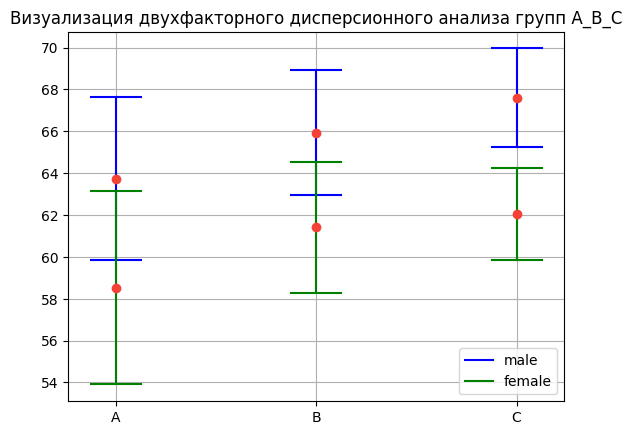

In [31]:
# визуализация двухфакторного дисперсного анализа для групп A B C
plt.title('Визуализация двухфакторного дисперсионного анализа групп A_B_С')
plt.xticks([1, 2, 3], ['A', 'B', 'C'])

plot_confidence_interval(1, df_A_male, color_chart='b', label='male')
plot_confidence_interval(2, df_B_male, color_chart='b')
plot_confidence_interval(3, df_C_male, color_chart='b')

plot_confidence_interval(1, df_A_female, color_chart='g', label='female')
plot_confidence_interval(2, df_B_female, color_chart='g')
plot_confidence_interval(3, df_C_female, color_chart='g')


plt.grid()
plt.legend(loc = 'lower right')
print('Результаты теста по матетике действительно зависят только от пола. Все средние значения входят в доверительные интервалы');

Результаты теста по математике зависят от обоих факторов


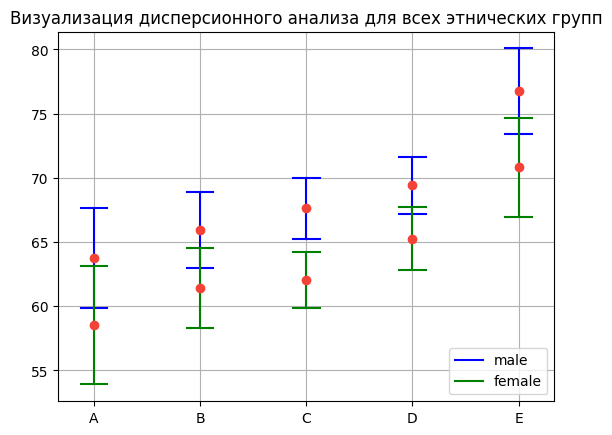

In [32]:
# построение графиков для двухфакторного дисперсного анализа
# исследуем данные результатов теста по математике в зависимости от пола и этнической принадлежности (gender, race)
plt.title('Визуализация дисперсионного анализа для всех этнических групп')
plt.xticks([1, 2, 3, 4, 5], ['A', 'B', 'C', 'D', 'E'])

plot_confidence_interval(1, df_A_male, color_chart='b', label='male')
plot_confidence_interval(2, df_B_male, color_chart='b')
plot_confidence_interval(3, df_C_male, color_chart='b')
plot_confidence_interval(4, df_D_male, color_chart='b')
plot_confidence_interval(5, df_E_male, color_chart='b')

plot_confidence_interval(1, df_A_female, color_chart='g', label='female')
plot_confidence_interval(2, df_B_female, color_chart='g')
plot_confidence_interval(3, df_C_female, color_chart='g')
plot_confidence_interval(4, df_D_female, color_chart='g')
plot_confidence_interval(5, df_E_female, color_chart='g')

plt.grid()
plt.legend(loc = 'lower right')
print('Результаты теста по математике зависят от обоих факторов');

0.018


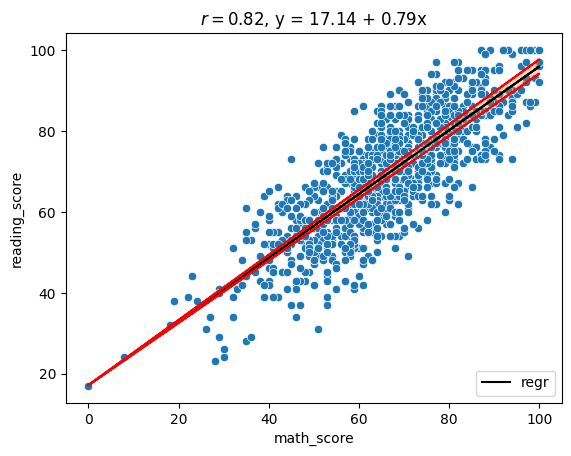

In [60]:
# Понятие корреляции. Линейная регрессия.
std_x = df.math_score.std()
std_y = df.reading_score.std()
y_mean = df.reading_score.mean()
x_mean = df.math_score.mean()
r = df.math_score.cov(df.reading_score)/(df.math_score.std()*df.reading_score.std())
# построение линейной регрессии
b1 = std_y/std_x*r
b0 = y_mean - b1*x_mean
Se_res = (np.sum((df.reading_score - (b0 + b1*df.math_score))**2)/(len(df) - 1))**(0.5) # оценка стандартной ошибки остатков
Se_b = Se_res/np.sum((df.math_score - x_mean)**2)**(0.5)
print(round(Se_b,3))
plt.title(f'$r = {round(r,2)}$, y = {round(b0,2)} + {round(b1,2)}x ')
sns.scatterplot(x=df.math_score, y = df.reading_score);
#print('Корреляция r равна = ', round(df.math_score.cov(df.reading_score)/(df.math_score.std()*df.reading_score.std()),2))
#sns.scatterplot(x=df.writing_score, y = df.reading_score)
D = r**2 # коэффициент детерминации
plt.plot(df.math_score, b0 + b1*df.math_score, 'black', label = 'regr')
plt.plot(df.math_score, b0 + (b1+Se_b)*df.math_score, 'r')
plt.plot(df.math_score, b0 + (b1-Se_b)*df.math_score, 'r')

x = np.linspace(0, 100, 1000)
plt.fill_between(x, b0 + (b1-Se_b)*x, b0 + (b1+Se_b)*x, alpha = 0.3)
plt.legend(loc='lower right');

In [61]:
# Если бы были сомнения, существует ли зависимость переменных, может быть использован t-тест для лин.регрессии
# t = (b1 - 0)/Se  , 0 - это предположение нулевой гипотезы, что наклона на самом деле никакого нет
# также будет найден p-value и будет проверена нулевая гипотеза

In [62]:
# чтобы не считать вручную, воспользуемся ols
result = ols(formula="reading_score ~ math_score", data=df).fit()
print(result.params)
print(result.summary()) # можно рассмотреть результат t-теста

Intercept     17.141807
math_score     0.787229
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          reading_score   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2012.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          1.79e-241
Time:                        12:21:08   Log-Likelihood:                -3547.5
No. Observations:                1000   AIC:                             7099.
Df Residuals:                     998   BIC:                             7109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

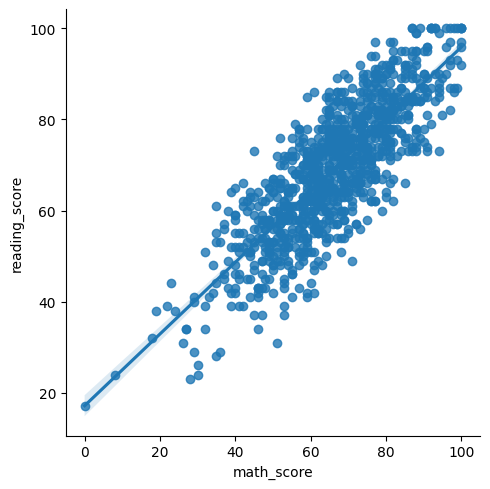

In [ ]:
# lmplot позволяет добавить линию регрессии без её нахождения
sns.lmplot(data=df, x='math_score', y='reading_score');
# уравнение линейной регрессии

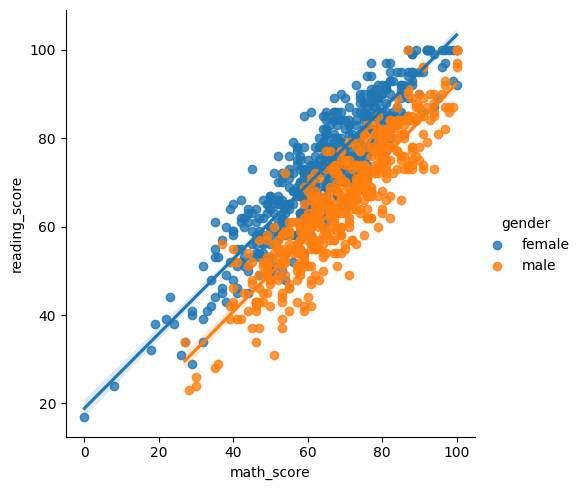

In [36]:
# lmplot также построить линейную регрессию при группировке
sns.lmplot(data=df, x='math_score', y='reading_score',hue = 'gender');